In [42]:
### import libs
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import networkx as nx
import heapq

In [43]:
### Map, start, goal
class graph_construction_discritization():
    
    def __init__(self, Map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discritization_angle):
        self.Map_qz = Map_qz
        self.start, self.goal = start, goal
        self.q_min, self.q_max, self.q_act = q_min, q_max, q_act
        self.discritization_angle = discritization_angle
        self.alpha, self.beta = alpha, beta
    
    def creating_nodes(self):
        # Precompute angles in radians
        angles = np.deg2rad(np.arange(0, 360+self.discritization_angle, self.discritization_angle))
        
        # Precompute the number of points per circle
        num_points_per_circle = len(angles)

        # Preallocate the array
        node_position_discritization = np.zeros((len(self.Map_qz) * num_points_per_circle + 2, 4))

        # index_map
        index_map = { (self.start[0], self.start[1], 0, self.q_act) : "s", (self.goal[0], self.goal[0], len(self.Map_qz)+1, self.q_act) : "g"}
        reverse_index_map = { value: key for key, value in index_map.items()}
        ### Adding the start and goal points
        node_position_discritization[0, 0] = self.start[0]
        node_position_discritization[0, 1] = self.start[1]
        node_position_discritization[0, 2] = 0
        node_position_discritization[0, 3] = self.q_act
        
        node_position_discritization[1, 0] = self.goal[0]
        node_position_discritization[1, 1] = self.goal[1]
        node_position_discritization[1, 2] = len(self.Map_qz)+1
        node_position_discritization[1, 3] = self.q_act
        
        ### Vectorized computation
        for i, (cx, cy, r) in enumerate(self.Map_qz):
            start_idx = i * num_points_per_circle + 2
            end_idx = start_idx + num_points_per_circle

            # Compute x and y positions using NumPy broadcasting
            x_vals = cx + r * np.cos(angles)
            y_vals = cy + r * np.sin(angles)

            # Assign values to the array
            node_position_discritization[start_idx:end_idx, 0] = x_vals
            node_position_discritization[start_idx:end_idx, 1] = y_vals
            node_position_discritization[start_idx:end_idx, 2] = i+1
            node_position_discritization[start_idx:end_idx, 3] = self.q_act
            
            index_map.update({(x_vals[j], y_vals[j], i+1, self.q_act): i*num_points_per_circle + j for j in range(x_vals.shape[0])})
            reverse_index_map.update({ value: key for key, value in index_map.items()})
            
        self.node_position_discritization = node_position_discritization
        
        return node_position_discritization, index_map, reverse_index_map
    
    def point_to_segment_distance(self,px, py, x1, y1, x2, y2):
        """Compute the minimum distance from a point (px, py) to a finite line segment (x1, y1) - (x2, y2)."""
        A = px - x1
        B = py - y1
        C = x2 - x1
        D = y2 - y1

        dot = A * C + B * D
        len_sq = C * C + D * D
        param = -1 if len_sq == 0 else dot / len_sq  # Projection parameter

        if param < 0:  # Closest to (x1, y1)
            xx, yy = x1, y1
        elif param > 1:  # Closest to (x2, y2)
            xx, yy = x2, y2
        else:  # Closest to the actual segment
            xx, yy = x1 + param * C, y1 + param * D

        dx, dy = px - xx, py - yy
        return np.sqrt(dx * dx + dy * dy)

    def line_segment_intersects_circle(self, circle, point1, point2):
        """Check if the finite line segment (point1 to point2) intersects the circle."""
        center_x, center_y, radius = circle
        x1, y1 = point1
        x2, y2 = point2

        return self.point_to_segment_distance(center_x, center_y, x1, y1, x2, y2) < radius
    
    def external_edge_addition(self, i, node_i, j, node_j, visibility_graph):

        distance = np.sqrt((node_i[0] - node_j[0])**2 + (node_i[1] - node_j[1])**2)                    
        SOC_i, SOC_j = int( node_i[3]),  int(node_j[3])
        line_segment = {}
        
        feasiblilty = False
        ### Feasibility check
        if SOC_j > min(self.q_max, SOC_i + self.beta*distance):
            feasiblilty = False
        
        elif (SOC_i - self.alpha*distance) < self.q_min and ( SOC_j <= SOC_i - self.alpha*distance):
            feasiblilty = True
            lamb = 1
            line_segment = {"e": (0, lamb)}
        else:
            lamb_1 = (self.q_max - SOC_i)/(self.beta*distance)
            lamb_2 = (self.q_max - SOC_j)/(self.alpha*distance)
            
            if lamb_1 >= 0 and lamb_2 >= 0 and (lamb_1 + lamb_2 <= 1):
                lamb = lamb_1 + self.alpha/(self.beta + self.alpha) * (1-lamb_1- lamb_2)
                lamb_2_sw = lamb_2 + self.beta/(self.beta + self.alpha) * (1-lamb_1- lamb_2)
                line_segment = {"g": (0, lamb_1) , "e": (lamb_1, lamb_2_sw) , "g": (lamb_2_sw, 1)}
            else:
                lamb = (SOC_j - SOC_i + self.alpha*distance)/((self.alpha + self.beta)*distance)
                line_segment = {"g": (0, lamb) , "e": (lamb, 1)}
            if lamb <= 1 and lamb >= 0:
                feasiblilty = True
        
        if feasiblilty:
            cost = lamb*distance
            visibility_graph.add_edge(i, j, node_i_info=node_i, node_j_info=node_j, line_segment=line_segment, fuel_cost=cost, risk_cost=0, feasiblilty=feasiblilty, edge_type="external")
            
        return visibility_graph
    
    def internal_edge_addition(self, i, node_i, j, node_j, visibility_graph):
        
        distance = np.sqrt((node_i[0] - node_j[0])**2 + (node_i[1] - node_j[1])**2)
        
        x_c, y_c, radius = self.Map_qz[int(node_i[2]-1)]
        
        pen_dist = sym.sqrt(radius**2-(distance/2)**2)
        
        SOC_i, SOC_j = int( node_i[3]),  int(node_j[3])
        line_segment = {}
        
        feasiblilty = False
        ### Feasibility check
        if SOC_j > min(self.q_max, SOC_i + self.beta*distance):
            feasiblilty = False
        
        elif (SOC_i - self.alpha*distance) < self.q_min and (SOC_j <= SOC_i - self.alpha*distance):
            feasiblilty = True
            lamb = 1
            line_segment = {"e": (0, lamb)}
        else:
            lamb_1 = (self.q_max - SOC_i)/(self.beta*distance)
            lamb_2 = (self.q_max - SOC_j)/(self.alpha*distance)
            
            if lamb_1 >= 0 and lamb_2 >= 0 and (lamb_1 + lamb_2 <= 1):
                lamb = lamb_1 + self.alpha/(self.beta + self.alpha) * (1-lamb_1- lamb_2)
                lamb_2_sw = lamb_2 + self.beta/(self.beta + self.alpha) * (1-lamb_1- lamb_2)
                line_segment = {"g": (0, lamb_1) , "e": (lamb_1, lamb_2_sw) , "g": (lamb_2_sw, 1)}
            else:
                lamb = (SOC_j - SOC_i + self.alpha*distance)/((self.alpha + self.beta)*distance)
                line_segment = {"g": (0, lamb) , "e": (lamb, 1)}
            if lamb <= 1 and lamb >= 0:
                feasiblilty = True
        
        if feasiblilty:
            cost = lamb*distance
            risk_cost = self.risk_cost_cal(line_segment, pen_dist, distance)
            visibility_graph.add_edge(i, j, node_i_info=node_i, node_j_info=node_j, line_segment=line_segment, fuel_cost=cost, risk_cost=risk_cost, feasiblilty=feasiblilty, edge_type="internal")
        
        return visibility_graph
    
    def risk_cost_cal(self, line_segment, pen_dist, distance):
        risk_cost = 0
        constant_factor = 30
        for key, value in line_segment.items():
            if key == "e":
                risk_cost += 0
            elif key == "g":
                lamb_start, lamb_end = value[0], value[1]
                if lamb_start <= 0.5 and lamb_end >= 0.5:
                    risk_cost += abs(1/(pen_dist+0.01)*(sym.atan((distance/2 - lamb_start*distance)/(pen_dist+0.01)) + sym.atan((lamb_end*distance - distance/2)/(pen_dist+0.01))))
                elif lamb_start >= 0.5 and lamb_end >= 0.5:
                    risk_cost += abs(1/(pen_dist+0.01)*(sym.atan((lamb_end*distance-distance/2)/(pen_dist+0.01)) - sym.atan((lamb_start*distance - distance/2)/(pen_dist+0.01))))
                elif lamb_start <= 0.5 and lamb_end <= 0.5:
                   risk_cost += abs(1/(pen_dist+0.01)*(sym.atan((distance/2- lamb_start*distance)/(pen_dist+0.01)) - sym.atan((distance/2-lamb_end*distance)/(pen_dist+0.01))))
        return constant_factor*risk_cost

In [44]:
# Define constants and initial conditions
Map_qz = [(0.0, 0.0, 6.0), (12.0, 10.0, 4.0)]  # QZ circles with (x, y, radius)
start = (-5, -5)  # Starting point
goal = (15, 15)   # Goal point

### The UAV characteristics
alpha, recharge_factor = 0.5, 2
beta = alpha/recharge_factor

q_min, q_max, q_act = 20, 100, 50
discritization_angle = 10
### Risk limit for each circle, temporary
Risk_limit = { circle: 30 for circle in Map_qz}

### Index Map
index_map_circle = {i: circle for i, circle in enumerate(Map_qz)}

In [45]:
graph_object = graph_construction_discritization(Map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discritization_angle)

nodes, index_map, reverse_index_map = graph_object.creating_nodes()

visibility_graph = nx.DiGraph()

for i, node_i in reverse_index_map.items():
    for j, node_j in reverse_index_map.items():
        if i != j:
            circle_i, circle_j = node_i[2], node_j[2]
            x_i, y_i = node_i[0], node_i[1]
            x_j, y_j = node_j[0], node_j[1]
            
            ### Case 1: internal edges
            if (circle_i == circle_j):
                visibility_graph = graph_object.internal_edge_addition(i, node_i, j, node_j, visibility_graph)
            else:
                for circle in Map_qz:
                    intersection_exists = graph_object.line_segment_intersects_circle(circle, (x_i, y_i), (x_j, y_j))
                    if intersection_exists:
                        break
                
                if not intersection_exists:
                    visibility_graph = graph_object.external_edge_addition(i, node_i, j, node_j, visibility_graph)

In [46]:
### Biobjective optimization

### Heuristic function
### As at each state, the SOC is the same
for i, node_i in reverse_index_map.items():
    node_goal = (goal[0], goal[1], len(Map_qz)+1, q_act)
    distance = sym.sqrt((node_goal[0] - node_i[0])**2 + (node_goal[1] - node_i[1])**2)
    heuristic_cost= alpha/(alpha + beta)*distance
    visibility_graph.nodes[i]['heuristic_cost'] = heuristic_cost

### Biobjective optimization
all_states = list(visibility_graph.nodes)


In [76]:
sols = { state: [] for state in all_states}
g2_min = { state: np.inf for state in all_states}
open_set = []
x =  [(0, 0, 0, 0,"s"), (None,None,None,None,None) ] ### start node (f1, f2, g1, g2, start state) and its parent node as None, x = ( start_node, parent_node)
goal_state = "g"
heapq.heappush(open_set, x)

reduce_factor = 1
import time
while open_set:
    node_expand = heapq.heappop(open_set)
    current_f1, current_f2, current_g1, current_g2, current_state  = node_expand[0]

    ### 1. if g2[node] >= g2_min[node] don't add
    ### 2. if f2[node] >= g2_min[goal] don't add
    if current_g2 >= reduce_factor*g2_min[current_state] or current_f2 >= reduce_factor*g2_min[goal_state]:
        continue
    
    g2_min[current_state] = current_g2
    sols[current_state].append(node_expand)
    
    if current_state == goal_state:
        continue
    
    for state in visibility_graph.successors(current_state):
        
        g1 = current_g1 + visibility_graph.edges[current_state, state]['fuel_cost']
        f1 = g1 + visibility_graph.nodes[state]['heuristic_cost']
        
        g2 = current_g2 + visibility_graph.edges[current_state, state]['risk_cost']
        f2 = g2 + 0 ### Zero heuristic for risk.
        
        # print(f"Total child node state: {x}")
        ### Prune if dominated
        if g2 >= reduce_factor*g2_min[state] or f2 >= reduce_factor*g2_min[goal_state]:
            continue
        
        child_node =[ (f1, f2, g1, g2, state), (current_f1, current_f2, current_g1, current_g2, current_state)]
        ### Else putting the node in the open set
        heapq.heappush(open_set, child_node)
        
    # count += 1

[]


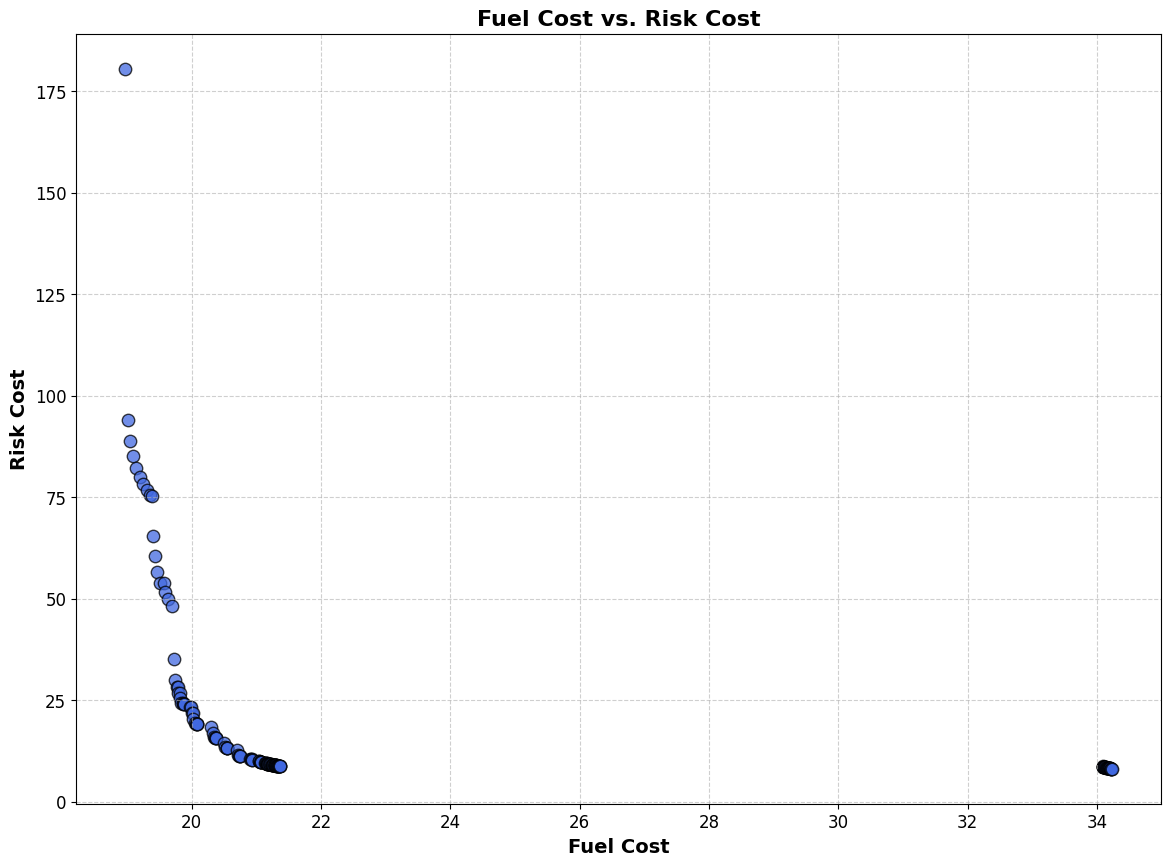

In [77]:
fuel_cost = [ node[0][0] for node in sols["g"]]
risk_cost = [ node[0][1] for node in sols["g"]]

### Check if the solutions are pareto optimal or not, by checking dominance relation
Dominated_array = []
for i in range(len(fuel_cost)):
    for j in range(i+1, len(fuel_cost)):
        if fuel_cost[i] <= fuel_cost[j] and risk_cost[i] <= risk_cost[j]:
            print("Dominated")
            Dominated_array.append(i)
        elif fuel_cost[i] >= fuel_cost[j] and risk_cost[i] >= risk_cost[j]:
            print("Dominated")
            Dominated_array.append(j)

print(Dominated_array)

### Scattter plot of fuel cost vs risk cost
plt.figure(figsize=(14, 10))
plt.scatter(fuel_cost, risk_cost, color='royalblue', edgecolors='black', alpha=0.75, s=80)  # Larger, more visible points
plt.xlabel("Fuel Cost", fontsize=14, fontweight='bold')
plt.ylabel("Risk Cost", fontsize=14, fontweight='bold')
plt.title("Fuel Cost vs. Risk Cost", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [78]:
#### All the path extracted from the solution
solution_paths = []
for current, parent in sols["g"]:
    parent_state = parent[-1]
    single_path = [current[-1]]
    cost = (current[0], current[1])
    while parent_state != "s":
        for parent_loop, grandparent_loop in sols[parent_state]:
            if parent_loop == parent:
                current = parent
                parent, parent_state = grandparent_loop, grandparent_loop[-1]
                single_path.append(current[-1])
                break
    single_path.append(parent[-1])
    single_path.reverse()
    single_path.append(cost)
    solution_paths.append(single_path)
solution_paths

[['s', 22, 5, 56, 44, 'g', (18.9720075212978, 180.508381822238)],
 ['s', 22, 6, 56, 44, 'g', (19.0184554790541, 93.9646205337760)],
 ['s', 22, 6, 55, 44, 'g', (19.0449673698721, 88.8176857497057)],
 ['s', 22, 6, 55, 45, 'g', (19.0866747803097, 85.0843789524698)],
 ['s', 22, 6, 54, 45, 'g', (19.1317706425192, 82.2562547617937)],
 ['s', 22, 6, 53, 45, 'g', (19.2048750677282, 80.0348368346055)],
 ['s', 22, 6, 53, 46, 'g', (19.2521060274539, 78.2341213232118)],
 ['s', 22, 6, 52, 46, 'g', (19.3092653829047, 76.7322254585660)],
 ['s', 22, 6, 52, 47, 'g', (19.3509498298477, 75.4456469669873)],
 ['s', 22, 6, 52, 51, 47, 'g', (19.3859238262883, 75.1868451474712)],
 ['s', 21, 6, 56, 44, 'g', (19.3988191806486, 65.5699938648224)],
 ['s', 21, 6, 55, 44, 'g', (19.4253310714666, 60.4230590807521)],
 ['s', 21, 6, 55, 45, 'g', (19.4670384819041, 56.6897522835162)],
 ['s', 21, 6, 54, 45, 'g', (19.5121343441137, 53.8616280928401)],
 ['s', 21, 6, 55, 46, 'g', (19.5690615024462, 53.8616280928401)],
 ['s',

In [79]:
### plotting the solution path
paths_with_22 = [ path for path in solution_paths if 22 in path]
paths_with_22_xy = [ [ reverse_index_map[index][:2] for index in path[:-1] ] for path in paths_with_22]


In [80]:
paths_with_22

[['s', 22, 5, 56, 44, 'g', (18.9720075212978, 180.508381822238)],
 ['s', 22, 6, 56, 44, 'g', (19.0184554790541, 93.9646205337760)],
 ['s', 22, 6, 55, 44, 'g', (19.0449673698721, 88.8176857497057)],
 ['s', 22, 6, 55, 45, 'g', (19.0866747803097, 85.0843789524698)],
 ['s', 22, 6, 54, 45, 'g', (19.1317706425192, 82.2562547617937)],
 ['s', 22, 6, 53, 45, 'g', (19.2048750677282, 80.0348368346055)],
 ['s', 22, 6, 53, 46, 'g', (19.2521060274539, 78.2341213232118)],
 ['s', 22, 6, 52, 46, 'g', (19.3092653829047, 76.7322254585660)],
 ['s', 22, 6, 52, 47, 'g', (19.3509498298477, 75.4456469669873)],
 ['s', 22, 6, 52, 51, 47, 'g', (19.3859238262883, 75.1868451474712)],
 ['s', 22, 9, 54, 44, 'g', (19.7300198876420, 35.1430649867848)],
 ['s', 22, 9, 53, 45, 'g', (19.7357037401885, 30.0935228689205)],
 ['s', 22, 9, 52, 45, 'g', (19.7654589379766, 28.2928073575267)],
 ['s', 22, 9, 53, 46, 'g', (19.7829346999142, 28.2928073575267)],
 ['s', 22, 9, 52, 46, 'g', (19.7894084949527, 26.7909114928810)],
 ['s',

In [81]:
len(paths_with_22_xy)

22

In [82]:
paths_with_22[2][-1][0]

19.0449673698721

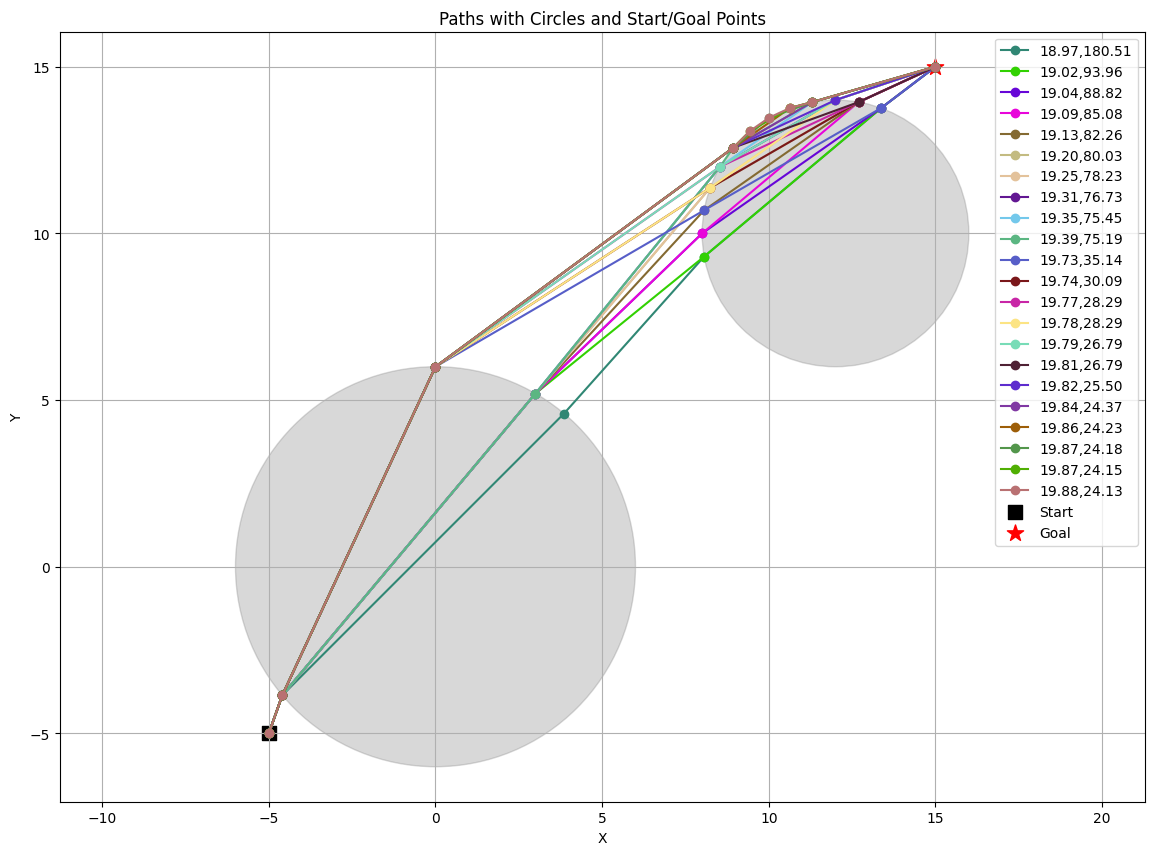

In [83]:
import random
##### Plotting the solution path for which passes thru certain state
plt.figure(figsize=(14, 10))
random.seed(42)
colors = ["#" + ''.join([random.choice('0123456789ABCDEF') for _ in range(6)]) for _ in range(len(paths_with_22_xy))]

for i, path in enumerate(paths_with_22_xy):
    x, y = zip(*path)
    plt.plot(x, y, marker='o', linestyle='-', color=colors[i], label=f'{float(paths_with_22[i][-1][0]):.2f},{float(paths_with_22[i][-1][1]):.2f}')

for x_c, y_c, r in Map_qz:
    circle = plt.Circle((x_c, y_c), r, color='gray', alpha=0.3, fill=True)
    plt.gca().add_patch(circle)

### Start and goal points
plt.scatter(start[0], start[0], color='black', marker='s', s=100, label='Start' )
plt.scatter(goal[0], goal[0], color='red', marker='*', s=150, label='Goal')

# Formatting
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis("equal")  # Ensure aspect ratio is equal
plt.grid(True)
plt.title("Paths with Circles and Start/Goal Points")
plt.show()

In [53]:
#### Modified BOAstar with only subset of solutions
alpha_mod, beta_mod = 0.7, 0.7
M_alpha_beta = np.array([[alpha_mod, 1-alpha_mod], [1-beta_mod, beta_mod]])

sols = { state: [] for state in all_states}
g2_min = { state: np.inf for state in all_states}
open_set = []

x =  [(0, 0, 0, 0,"s"), (None,None,None,None,None) ] ### start node (f1, f2, g1, g2, start state) and its parent node as None, x = ( start_node, parent_node)

goal_state = "g"
heapq.heappush(open_set, x)
count = 0

while open_set:
    node_expand = heapq.heappop(open_set)
    current_f1, current_f2, current_g1, current_g2, current_state  = node_expand[0]
    
    ### 1. if g2[node] >= g2_min[node] don't add
    ### 2. if f2[node] >= g2_min[goal] don't add
    if current_g2 >= g2_min[current_state] or current_f2 >= g2_min[goal_state]:
        continue
    
    g2_min[current_state] = current_g2
    sols[current_state].append(node_expand)
    
    if current_state == goal_state:
        continue
    
    for state in visibility_graph.successors(current_state):
        edge_g1 = visibility_graph.edges[current_state, state]['fuel_cost']
        edge_g2 = visibility_graph.edges[current_state, state]['risk_cost']
        edge_h = visibility_graph.nodes[state]['heuristic_cost']
        
        edge_g1_mod = alpha_mod*edge_g1 + (1-alpha_mod)*edge_g2
        edge_g2_mod = beta_mod*edge_g2  + (1-beta_mod)*edge_g1
        edge_h1_mod = alpha_mod*edge_h
        edge_h2_mod = (1-beta_mod)*edge_h

        g1 = current_g1 + edge_g1_mod
        f1 = g1 + edge_h1_mod
        
        g2 = current_g2 + edge_g2_mod
        f2 = g2 + edge_h2_mod ### Zero heuristic for risk.
        
        # print(f"Total child node state: {x}")
        ### Prune if dominated
        if g2 >= g2_min[state] or f2 >= g2_min[goal_state]:
            continue
        
        child_node =[ (f1, f2, g1, g2, state), (current_f1, current_f2, current_g1, current_g2, current_state)]
        ### Else putting the node in the open set
        heapq.heappush(open_set, child_node)
        
    # count += 1

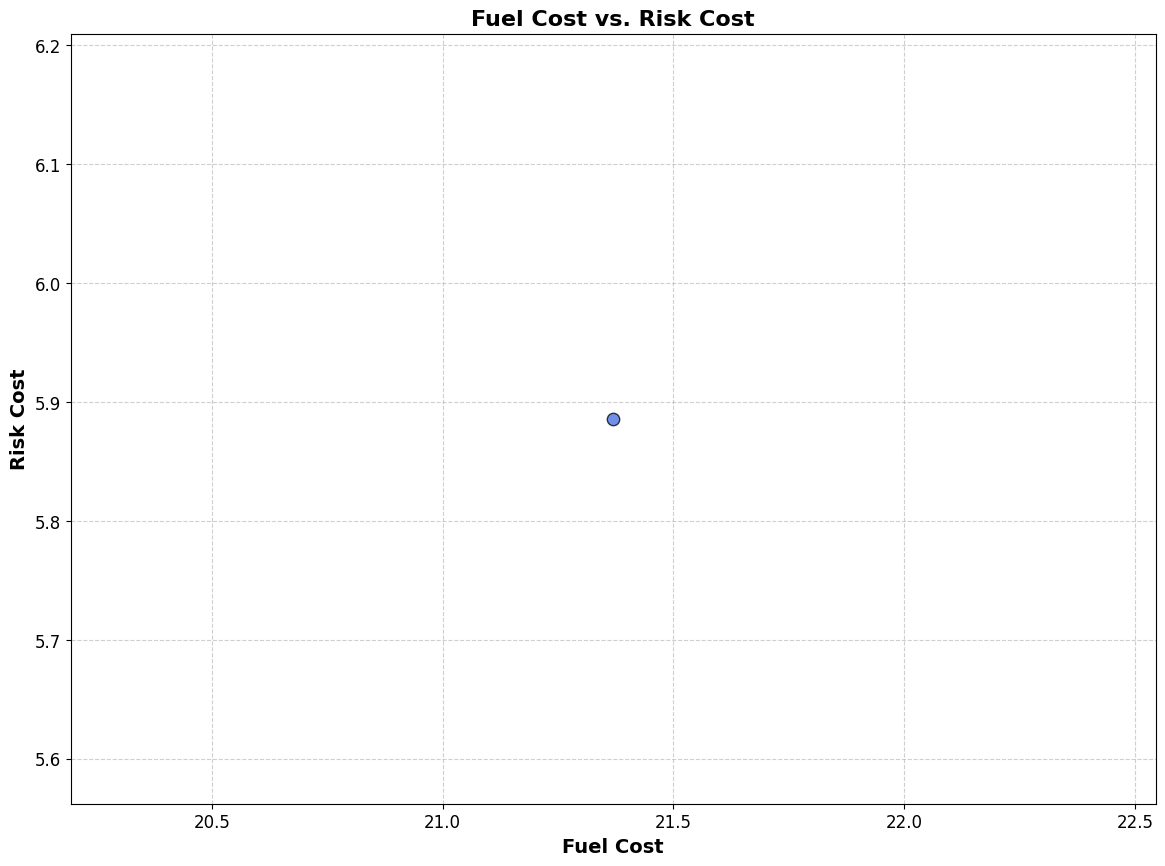

In [54]:
fuel_cost = np.array([ float(node[0][0]) for node in sols["g"]])
risk_cost = np.array([ float(node[0][1]) for node in sols["g"]])

M_inv = np.linalg.inv(M_alpha_beta)
fuel_cost = M_inv[0,0]*fuel_cost + M_inv[0,1]*risk_cost
risk_cost = M_inv[1,0]*fuel_cost + M_inv[1,1]*risk_cost
### Scattter plot of fuel cost vs risk cost
plt.figure(figsize=(14, 10))
plt.scatter(fuel_cost, risk_cost, color='royalblue', edgecolors='black', alpha=0.75, s=80)  # Larger, more visible points
plt.xlabel("Fuel Cost", fontsize=14, fontweight='bold')
plt.ylabel("Risk Cost", fontsize=14, fontweight='bold')
plt.title("Fuel Cost vs. Risk Cost", fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [55]:
#### All the path extracted from the solution
solution_paths = []
for current, parent in sols["g"]:
    parent_state = parent[-1]
    single_path = [current[-1]]
    while parent_state != "s":
        for parent_loop, grandparent_loop in sols[parent_state]:
            if parent_loop == parent:
                current = parent
                parent, parent_state = grandparent_loop, grandparent_loop[-1]
                single_path.append(current[-1])
                break
    single_path.append(parent[-1])
    single_path.reverse()
    solution_paths.append(single_path)

solution_paths

[['s', 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 51, 50, 49, 48, 47, 'g']]